# **Process pseudobulks for subtype prediction**


You will run this 3 times, one for cellType, granular, and subtype pseudobulks
You can edit this in the parameters res_name and celltype_name


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-08 15:38:09.336930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 15:38:09.356784: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 15:38:09.555262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 15:38:09.730218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736375889.868771 2507094 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736375889.90

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE165897_pseudobulks/"


exp_id = "all-cellType" # cellType subtype granular

if exp_id == "all-cellType":
    res_id = "cellType" 
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all_subtype":
    res_id = "subtype"


curr_treatment = "drug"
result_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [3]:
# now get the sc ref training data

# read in order
# oritinal samples
sample_order = ['Samp_EOC372_primary_Peritoneum',
                  'Samp_EOC372_interval_Peritoneum',
                  'Samp_EOC443_interval_Omentum',
                  'Samp_EOC443_primary_Omentum',
                  'Samp_EOC540_interval_Omentum',
                  'Samp_EOC3_interval_Omentum',
                  'Samp_EOC3_primary_Peritoneum',
                  'Samp_EOC87_interval_Omentum',
                  'Samp_EOC87_primary_Peritoneum',
                  'Samp_EOC136_interval_Omentum',
                  'Samp_EOC136_primary_Mesentery',
                  'Samp_EOC1005_primary_Peritoneum',
                  'Samp_EOC1005_interval_Tumor',
                  'Samp_EOC733_primary_Peritoneum',
                  'Samp_EOC733_interval_Omentum',
                  'Samp_EOC153_interval_Omentum',
                  'Samp_EOC153_primary_Omentum',
                  'Samp_EOC349_interval_Omentum',
                  'Samp_EOC349_primary_Peritoneum',
                  'Samp_EOC227_interval_Omentum',
                  'Samp_EOC227_primary_Omentum']


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, _, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



Samp_EOC372_primary_Peritoneum
Samp_EOC372_interval_Peritoneum
Samp_EOC443_interval_Omentum
Samp_EOC443_primary_Omentum
Samp_EOC540_interval_Omentum
Samp_EOC3_interval_Omentum
Samp_EOC3_primary_Peritoneum
Samp_EOC87_interval_Omentum
Samp_EOC87_primary_Peritoneum
Samp_EOC136_interval_Omentum
Samp_EOC136_primary_Mesentery
Samp_EOC1005_primary_Peritoneum
Samp_EOC1005_interval_Tumor
Samp_EOC733_primary_Peritoneum
Samp_EOC733_interval_Omentum
Samp_EOC153_interval_Omentum
Samp_EOC153_primary_Omentum
Samp_EOC349_interval_Omentum
Samp_EOC349_primary_Peritoneum
Samp_EOC227_interval_Omentum
Samp_EOC227_primary_Omentum


In [4]:
gene_df

gene_ids
RP11-34P13.7      RP11-34P13.7
RP11-34P13.8      RP11-34P13.8
CICP27                  CICP27
RP11-34P13.15    RP11-34P13.15
RP11-34P13.13    RP11-34P13.13
                     ...      
MT-ND6                  MT-ND6
MT-TE                    MT-TE
MT-CYB                  MT-CYB
MT-TT                    MT-TT
MT-TP                    MT-TP
Name: gene_ids, Length: 32843, dtype: object

In [5]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
1,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
2,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
3,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
4,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref


In [6]:
X_concat

gene_ids,RP11-34P13.7,RP11-34P13.8,CICP27,RP11-34P13.15,RP11-34P13.13,FO538757.1,AP006222.2,RP4-669L17.2,RP4-669L17.10,RP5-857K21.4,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,3.0,1.0,...,8170.0,1.0,0.0,1.0,2123.0,219.0,0.0,7110.0,4.0,0.0
0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,6783.0,0.0,0.0,0.0,1697.0,123.0,0.0,5763.0,4.0,0.0
0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,...,8690.0,0.0,0.0,0.0,2472.0,155.0,0.0,7788.0,4.0,0.0
0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,8645.0,0.0,0.0,0.0,2926.0,104.0,0.0,8481.0,7.0,0.0
0,0.0,0.0,0.0,3.0,5.0,2.0,3.0,0.0,2.0,3.0,...,26612.0,5.0,0.0,6.0,6852.0,551.0,0.0,19056.0,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,...,3356.0,23.0,0.0,0.0,1084.0,87.0,3.0,2527.0,16.0,20.0
0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,...,2410.0,11.0,0.0,0.0,769.0,44.0,1.0,1774.0,20.0,12.0
0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,0.0,0.0,0.0,...,2371.0,9.0,0.0,0.0,735.0,61.0,1.0,1914.0,21.0,9.0
0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,...,2803.0,9.0,0.0,0.0,845.0,57.0,1.0,2167.0,22.0,25.0


In [7]:
# double check all the pseudobulks/bulks were read in
meta_concat.sample_id.value_counts()

Samp_EOC372_primary_Peritoneum     1300
Samp_EOC372_interval_Peritoneum    1300
Samp_EOC443_interval_Omentum       1300
Samp_EOC443_primary_Omentum        1300
Samp_EOC540_interval_Omentum       1300
Samp_EOC3_interval_Omentum         1300
Samp_EOC3_primary_Peritoneum       1300
Samp_EOC87_interval_Omentum        1300
Samp_EOC87_primary_Peritoneum      1300
Samp_EOC136_interval_Omentum       1300
Samp_EOC136_primary_Mesentery      1300
Samp_EOC1005_primary_Peritoneum    1300
Samp_EOC1005_interval_Tumor        1300
Samp_EOC733_primary_Peritoneum     1300
Samp_EOC733_interval_Omentum       1300
Samp_EOC153_interval_Omentum       1300
Samp_EOC153_primary_Omentum        1300
Samp_EOC349_interval_Omentum       1300
Samp_EOC349_primary_Peritoneum     1300
Samp_EOC227_interval_Omentum       1300
Samp_EOC227_primary_Omentum        1300
Name: sample_id, dtype: int64

In [8]:
Y_concat

,EOC,Stromal,Immune
0,0.230000,0.085000,0.685000
0,0.170000,0.005000,0.825000
0,0.130000,0.245000,0.625000
0,0.005000,0.850000,0.145000
0,0.925000,0.005000,0.070000
...,...,...,...
0,0.005279,0.070310,0.924412
0,0.006093,0.002303,0.991603
0,0.010740,0.013902,0.975358
0,0.001283,0.003975,0.994742


# Plot all data

In [9]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
1,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
2,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
3,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
4,Samp_EOC372_primary_Peritoneum,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1295,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1296,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1297,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref
1298,Samp_EOC227_primary_Omentum,CTRL,Train,cell_type_specific,sc_ref


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.053s...
[t-SNE] Computed neighbors for 1000 samples in 0.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 22069.220006
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.296051
[t-SNE] KL divergence after 500 iterations: 0.479238
(1000, 2)
(1000, 2)


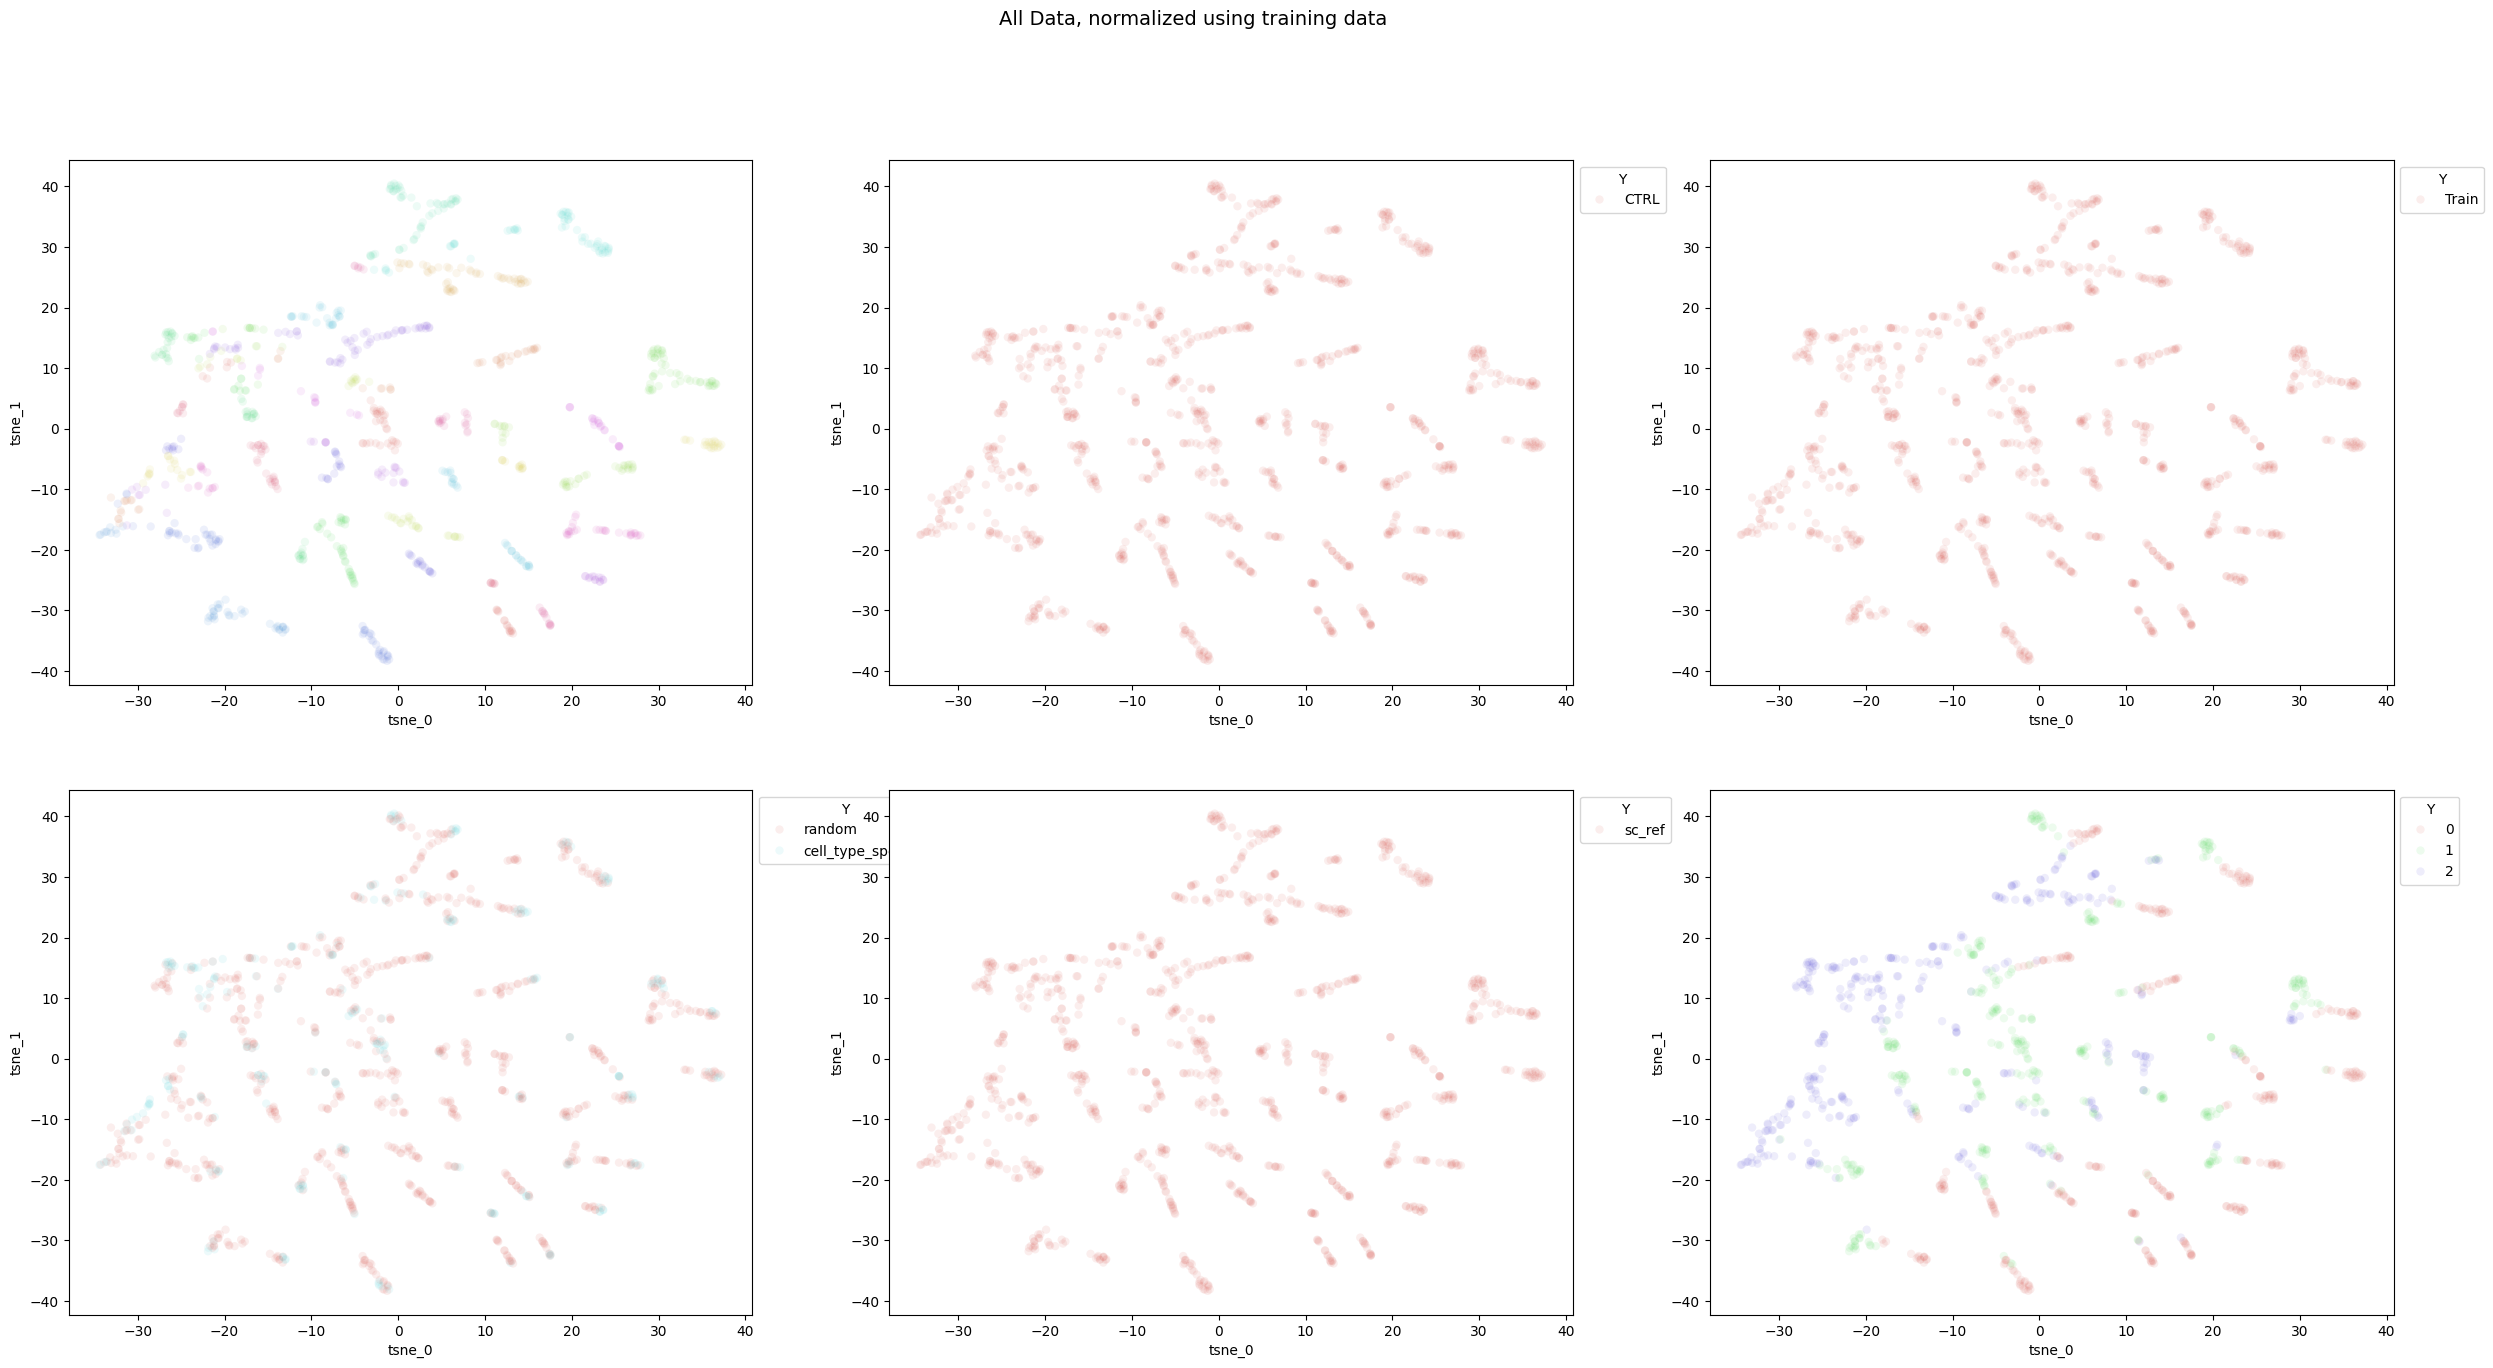

In [10]:
## plot samples
idx_tmp = np.random.choice(range(X_concat.shape[0]), 1000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_concat.iloc[idx_tmp])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_concat.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


In [11]:
Y_concat

,EOC,Stromal,Immune
0,0.230000,0.085000,0.685000
0,0.170000,0.005000,0.825000
0,0.130000,0.245000,0.625000
0,0.005000,0.850000,0.145000
0,0.925000,0.005000,0.070000
...,...,...,...
0,0.005279,0.070310,0.924412
0,0.006093,0.002303,0.991603
0,0.010740,0.013902,0.975358
0,0.001283,0.003975,0.994742


In [12]:
X_concat

gene_ids,RP11-34P13.7,RP11-34P13.8,CICP27,RP11-34P13.15,RP11-34P13.13,FO538757.1,AP006222.2,RP4-669L17.2,RP4-669L17.10,RP5-857K21.4,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,3.0,1.0,...,8170.0,1.0,0.0,1.0,2123.0,219.0,0.0,7110.0,4.0,0.0
0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,6783.0,0.0,0.0,0.0,1697.0,123.0,0.0,5763.0,4.0,0.0
0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,...,8690.0,0.0,0.0,0.0,2472.0,155.0,0.0,7788.0,4.0,0.0
0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,...,8645.0,0.0,0.0,0.0,2926.0,104.0,0.0,8481.0,7.0,0.0
0,0.0,0.0,0.0,3.0,5.0,2.0,3.0,0.0,2.0,3.0,...,26612.0,5.0,0.0,6.0,6852.0,551.0,0.0,19056.0,27.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,...,3356.0,23.0,0.0,0.0,1084.0,87.0,3.0,2527.0,16.0,20.0
0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,...,2410.0,11.0,0.0,0.0,769.0,44.0,1.0,1774.0,20.0,12.0
0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,0.0,0.0,0.0,...,2371.0,9.0,0.0,0.0,735.0,61.0,1.0,1914.0,21.0,9.0
0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,...,2803.0,9.0,0.0,0.0,845.0,57.0,1.0,2167.0,22.0,25.0


In [13]:
pd.DataFrame(gene_df)

,gene_ids
gene_ids,
RP11-34P13.7,RP11-34P13.7
RP11-34P13.8,RP11-34P13.8
CICP27,CICP27
RP11-34P13.15,RP11-34P13.15
RP11-34P13.13,RP11-34P13.13
...,...
MT-ND6,MT-ND6
MT-TE,MT-TE
MT-CYB,MT-CYB


In [14]:
result_ad_file_tsv = f"{sc_aug_data_path}/{exp_id}.tsv"
X_concat.to_csv(result_ad_file_tsv, sep="\t")

In [15]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/2_format_write_pseudobulk/../../data/single_cell/GSE165897_pseudobulks//all-cellType.h5ad'

In [16]:

# make anndata

# write out anndata for R to run consensusOV

meta_concat.index = range(0,meta_concat.shape[0])
Y_concat.index = meta_concat.index
X_concat.index = meta_concat.index
X_concat.columns

full_meta = pd.concat([meta_concat, Y_concat], axis=1)

adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))

adata.write(result_ad_file)

adata

/tmp/ipykernel_2507094/4003203352.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 27300 × 32843
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'EOC', 'Stromal', 'Immune'
    var: 'gene_ids'